In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
#import seaborn as sns
import math
from scipy import signal

In [2]:
# 지수 표현 제거
pd.options.display.float_format = '{:.5f}'.format

# Normal signal

In [3]:
# sampling rate
fs = 1000000 # 1MHz

# signal length
t = np.arange(0, 0.2, 1 / fs) # s, sampling interval, time array

# generate signal
f1 = 60 # 60Hz
signal_f = 2*np.sin(2*np.pi*f1*t)  # amplitude = 2

# generate noise signal
np.random.seed(222)
n1 = np.random.uniform(1000000, 1500000, len(t)) # 1MHz ~ 1.5 MHz
signal_n = 0.2*np.sin(2*np.pi*n1*t)

# total signal
normal_signal = signal_f + signal_n

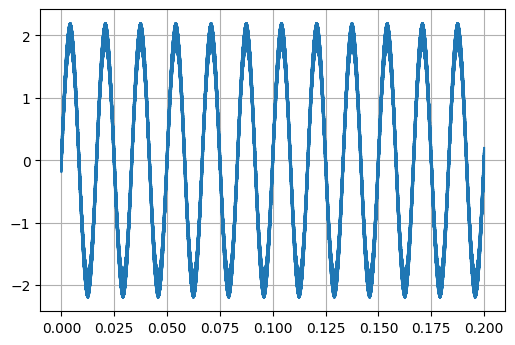

In [4]:
# visualizing signal

plt.figure(num = 1, dpi = 100)
plt.plot(t, normal_signal)
plt.grid()

# Arc signal

In [5]:
#  generate noise Arc signal

n3 = 4000000 # 4MHz

np.random.seed(333)
random_mag_Arc = np.random.uniform(0.8, 1.1, 1500)
signal_Arc = random_mag_Arc*np.sin(2*np.pi*n3*t[82500:84000])

signal_Arc # 아크 신호

array([-3.39161411e-10, -4.00557904e-10, -3.49578446e-10, ...,
       -4.41900272e-11, -5.36427316e-10, -6.39440952e-10])

In [6]:
temp = list(normal_signal) # shoulder 범위만 아크 신호를 더해주기 위해 타입변환

# shoulder 범위만 아크 신호 더하고 shoulder 범위가 아닌 부분은 아크신호를 더하지 않음.

import random
num_s =[] # shoulder 부분 Counting 역할

i,j = 1, 0
s0 = temp[82500*0+1500*0:82500*1+1500*0]
end = (82500*1)+(1500*0)

while (len(s0) < 200000):
    start = end
    np.random.seed(0)
    num = random.randint(0,1) # 아크 신호를 랜덤하기 더해주기 위한 규칙 생성
    num_s.append(num)
    
    if i == j: # shoulder 범위가 아닐때 그냥 신호 더해줌.
        i += 1
        end = (82500*i)+(1500*j)
        s0 = s0+temp[start:end]
    elif i!=j and num == 1: # shoulder 범위 이면서 num == 2일 경우 아크 신호 더함.
        j += 1
        end = (82500*i)+(1500*j)
        x = temp[start:end] + signal_Arc
        s0 = s0+ list(x) 
    else: # shoulder 범위 이나 num은 2가 아닐 경우 노말 신호만 더해줌.
        j += 1
        end = (82500*i)+(1500*j)
        s0 = s0+ temp[start:end] 
        
sig = np.array(s0) # numpy array type으로 변환

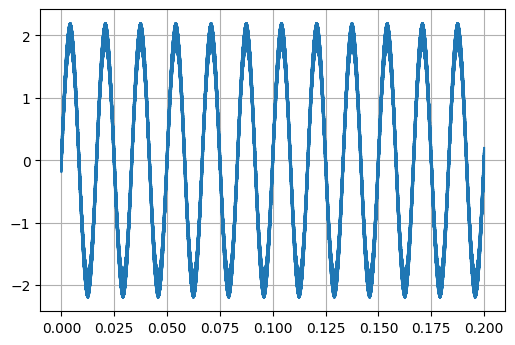

In [7]:
# visualizing signal (노말과 아크 상태를 추가하여 완성된 신호)

plt.figure(num = 1, dpi = 100)
plt.plot(t, sig)
plt.grid()

In [8]:
import pandas as pd

dat_df = pd.DataFrame({'time':t, 'mag':sig})

# 데이터 파일 csv 형식으로 저장.
dat_df.to_csv('dat_df.csv', index = False)

In [9]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import RobustScaler, MaxAbsScaler, StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, RepeatVector, TimeDistributed

In [10]:
sig_df = pd.read_csv('dat_df.csv')
sig_df.set_index(sig_df['time'], inplace=True)
sig_df.drop(['time'], axis = 1, inplace = True)
sig_df

,mag
time,
0.00000,0.00000
0.00000,0.16781
0.00000,-0.17021
0.00000,-0.02200
0.00000,0.09274
...,...
0.20000,0.02347
0.20000,0.08175
0.20000,0.18777


In [11]:
train_size = int(len(sig_df) * 0.95)
test_size = len(sig_df) - train_size
train, test = sig_df.iloc[0:train_size], sig_df.iloc[train_size:len(sig_df)]
print(train.shape, test.shape)

(190000, 1) (10001, 1)


In [12]:
scaler = StandardScaler()
scaler = scaler.fit(train[['mag']])

train['mag'] = scaler.transform(train[['mag']])
test['mag'] = scaler.transform(test[['mag']])

/home/wkchoi/anaconda3/envs/etri/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/wkchoi/anaconda3/envs/etri/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [13]:
TIME_STEPS=500

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['mag']], train['mag'])
X_test, y_test = create_sequences(test[['mag']], test['mag'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (189500, 500, 1)
Testing shape: (9501, 500, 1)


In [55]:
print(f'Training shape: {y_train.shape}')
print(f'Testing shape: {y_test.shape}')

Training shape: (189500,)
Testing shape: (9501,)


In [90]:
print(X_train)

[[[-0.03565123]
  [ 0.08213786]
  [-0.15512615]
  ...
  [ 0.25531212]
  [ 0.08933558]
  [ 0.3215818 ]]

 [[ 0.08213786]
  [-0.15512615]
  [-0.05109155]
  ...
  [ 0.08933558]
  [ 0.3215818 ]
  [ 0.12067151]]

 [[-0.15512615]
  [-0.05109155]
  [ 0.02944767]
  ...
  [ 0.3215818 ]
  [ 0.12067151]
  [ 0.35739575]]

 ...

 [[ 1.11035857]
  [ 1.05546214]
  [ 1.12664407]
  ...
  [ 0.78331239]
  [ 0.84609175]
  [ 0.91681165]]

 [[ 1.05546214]
  [ 1.12664407]
  [ 1.07112641]
  ...
  [ 0.84609175]
  [ 0.91681165]
  [ 0.84564687]]

 [[ 1.12664407]
  [ 1.07112641]
  [ 1.0730302 ]
  ...
  [ 0.91681165]
  [ 0.84564687]
  [ 0.92333055]]]


In [91]:
print(y_train)

[0.12067151 0.35739575 0.10146708 ... 0.84564687 0.92333055 0.91505862]


In [86]:
model = tf.keras.Sequential([
                             tf.keras.layers.LSTM(units = 32, return_sequences=True, input_shape=[500, 1]),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.LSTM(units = 32, return_sequences=True),

                             tf.keras.layers.Dense(units = 1, activation = 'relu')
])

model.compile(optimizer='adam', loss='binary_crossentropy')   #'rmsprop' 
model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_69 (LSTM)               (None, 500, 32)           4352      
_________________________________________________________________
dropout_39 (Dropout)         (None, 500, 32)           0         
_________________________________________________________________
lstm_70 (LSTM)               (None, 500, 32)           8320      
_________________________________________________________________
dense_41 (Dense)             (None, 500, 1)            33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [87]:
history = model.fit(X_train, y_train, epochs = 10, batch_size = 64, validation_split=0.1)

Epoch 1/10
 170/2665 [>.............................] - ETA: 1:01 - loss: -7.4268

KeyboardInterrupt: 

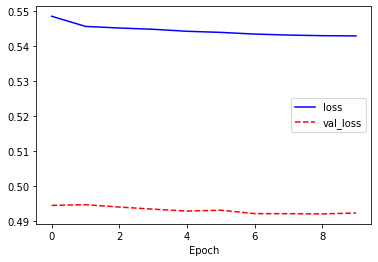

In [26]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], 'b-', label = 'loss')
plt.plot(history.history['val_loss'], 'r--', label = 'val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
prediction = model.predict(X_test)

for i in range(len(X_test)):
    print(Y_test[i], '\t', prediction[i], '\tdiff:', abs(prediction[i] - Y_test[i]))

prediction = model.predict(X_test)
fail = 0
for i in range(len(prediction)):
  for j in range(6):
    if abs(prediction[i][j] - Y_test[i][j]) > 0.1:
      fail += 1
print('correctness:', (129 - fail) / 129*100, '%')

In [ ]:
model.save('arc.h5')

In [ ]:
model = load_model('arc.h5')

In [ ]:
#model = Sequential()
#model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(Dropout(rate=0.2))
#model.add(Dense(1, activation = 'sigmoid'))
#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = ['acc'])
#model.summary()

In [ ]:
#history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.1,)

In [ ]:
#plt.plot(history.history['loss'], label='Training loss')
#plt.plot(history.history['val_loss'], label='Validation loss')
#plt.legend();

In [ ]:
#model.evaluate(X_test, y_test)